In [17]:
import pandas as pd
import numpy as np

## 1 - Prepare data

In [18]:
# Get data
df = pd.read_csv(
    '/home/templar/Desktop/projects/zaz/client-projects/ai-bobby-classification/data/raw/gelation_hardness_dec_2024.csv',
    dtype={
        'Treatment code': object,
        'Protein codes': object,
        'Type of salt': object,
        'Additives': object,
    }
)

# Define categorical columns
categorical_columns = ['Protein codes', 'Type of salt', 'Additives', 'Treatment code']

# Define numeric columns
numerical_columns = [
    'Samples stored (°C)',
    'ionic strength (M)',
    'Additives Concentration (%)',
    'Protein Concentration (%)',
    'pH',
    'Heating temperature (°C) for gel preparation',
    'Heating/hold time (min)',
    'Hardness/firmness/strength (g)'
]

# Convert object columns to categorical
for col in categorical_columns:
    df[col] = df[col].astype('object')

# Convert columns to numeric
for col in numerical_columns:
    df[col] = df[col].astype('float64')

# Columns to drop
columns_to_drop = [
    'Citation',
    'Citation Link',
    'Protein',
    'Treatment condition code',
    'Treatment condition value',
    'Treatment temperature ( °C)',
    'Treatment time (min)',
    'Storage time (h)',
    'If a gel can be formed (0-1)',
]

# Drop columns
df_clean = df.drop(columns=columns_to_drop, axis=1)

# Drop rows with missing target values
df_clean = df_clean.dropna(subset=['Hardness/firmness/strength (g)'])

### Transform target variable
- Soft gel = 0 to 1000 grams (upto 10 Newtons)
- Firm gel = 1000 to 5000 grams (50 Newtons)
- Rigid gel/stable gel = 5000 to 1,000,000 grams


In [19]:
def categorize_gel_strength(dataframe: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """
    Categorizes a continuous column into gel strength categories.

    Parameters:
    dataframe (pd.DataFrame): Input DataFrame.
    column_name (str): Name of the column to be transformed.

    Returns:
    pd.DataFrame: DataFrame with a new column `<column_name>_category` containing the categories.
    """
    # Define the bins and labels
    bins = [0, 1000, 5000, 1000000]
    labels = [0, 1, 2] # Soft, Firm, Rigid

    # Create a new column for the categories
    category_column_name = f"{column_name}_category"
    dataframe[category_column_name] = pd.cut(
        dataframe[column_name], bins=bins, labels=labels, include_lowest=True
    )

    return dataframe

In [20]:
df_clean = categorize_gel_strength(df_clean, 'Hardness/firmness/strength (g)')
df_clean.head()

,Protein codes,Protein Concentration (%),Treatment code,Additives,Additives Concentration (%),pH,Type of salt,ionic strength (M),Heating temperature (°C) for gel preparation,Heating/hold time (min),Samples stored (°C),Hardness/firmness/strength (g),Hardness/firmness/strength (g)_category
0,10501,12.0,NaN,NaN,NaN,5.0,NaN,NaN,90.0,30.0,4.0,131.91,0
1,10501,12.0,NaN,80203,0.5,5.0,NaN,NaN,90.0,30.0,4.0,155.91,0
2,10501,12.0,NaN,80203,1.0,5.0,NaN,NaN,90.0,30.0,4.0,151.14,0
3,10501,12.0,NaN,80203,2.0,5.0,NaN,NaN,90.0,30.0,4.0,144.84,0
4,10501,12.0,NaN,NaN,NaN,6.0,NaN,NaN,90.0,30.0,4.0,95.71,0


In [21]:
df_clean.drop(columns=['Hardness/firmness/strength (g)'], inplace=True)

In [22]:
df_clean['Hardness/firmness/strength (g)_category'].value_counts()

Hardness/firmness/strength (g)_category
0    863
1     88
2     54
Name: count, dtype: int64

In [23]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 12 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   Protein codes                                 1005 non-null   object  
 1   Protein Concentration (%)                     1005 non-null   float64 
 2   Treatment code                                587 non-null    object  
 3   Additives                                     588 non-null    object  
 4   Additives Concentration (%)                   568 non-null    float64 
 5   pH                                            863 non-null    float64 
 6   Type of salt                                  479 non-null    object  
 7   ionic strength (M)                            479 non-null    float64 
 8   Heating temperature (°C) for gel preparation  867 non-null    float64 
 9   Heating/hold time (min)                       867 no

In [24]:
X = df_clean.drop('Hardness/firmness/strength (g)_category', axis=1)
y = df_clean['Hardness/firmness/strength (g)_category']

## 2 - Train models

In [25]:
from warnings import filterwarnings
filterwarnings('ignore')
from flaml import AutoML

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
automl_settings = {
    "time_budget": 10,  # total running time in seconds
    "metric": 'log_loss',
    "task": 'classification',
    "estimator_list": ['lgbm', 'catboost', 'rf', 'xgboost', 'extra_tree'],
    "split_type": 'stratified',
    "n_jobs": -1,
    "log_file_name": 'automl.log',
    "verbose": 0,
    "seed": 42,
    "early_stop": True
}

automl = AutoML(**automl_settings)
automl.fit(X_train, y_train, task="classification")

In [26]:
automl.best_estimator

'lgbm'

In [27]:
automl.best_config

{'n_estimators': 19,
 'num_leaves': 11,
 'min_child_samples': 8,
 'learning_rate': 0.22926234904753484,
 'log_max_bin': 10,
 'colsample_bytree': 0.832361601243933,
 'reg_alpha': 0.0026060083505422683,
 'reg_lambda': 0.5487740986174037}

In [28]:
y_pred = automl.predict(X_test)

## 3 - Confusion matrix for best model

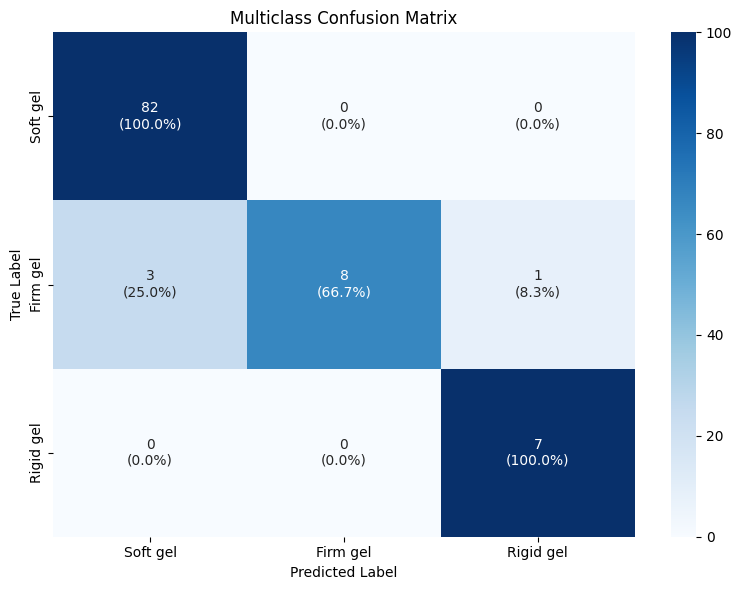

In [29]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Class labels
class_names = ["Soft gel", "Firm gel", "Rigid gel"]

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)  # Raw counts
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')  # Normalize by row to get percentages

# Convert to percentage and format as string
cm_percentage = cm_normalized * 100
cm_labels = np.array([f"{count}\n({value:.1f}%)" for count, value in zip(cm.flatten(), cm_percentage.flatten())]).reshape(cm.shape)

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=cm_labels, fmt='', cmap="Blues", xticklabels=class_names, yticklabels=class_names)

# Add title and labels
plt.title("Multiclass Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [30]:
print(f1_score(y_test, y_pred, average='micro'))


0.9603960396039604


In [31]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.9603960396039604


## 4 - Save model as joblib object

In [32]:
import joblib
joblib.dump(automl, 'model.joblib')

['model.joblib']

In [33]:
# load model and predict
loaded_model = joblib.load('model.joblib')
loaded_model.predict(X_test)

array([0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0])